# Image Classification - MNIST Dataset

The MNIST dataset contains 60,000 training and 10,000 testing examples of labaled hand-written grayscale digits from 0 to 9. Each image is 28x28 pixels, but these will be flattened into 768 dimensions, which will serve as features for the MLP.

Trains a MLP with 3 layers, dropout, batch normalization and hidden relu activations. $R = 768$, $S_M = 10$. The output function is a Log-Softmax, and the MLP is trained to minimized a Categorical Cross-Entropy performance index.

New Code
- Loading data from keras.datasets.
- Dropouts and Batch Normalization.
- Using model.add on a sequential model to add an arbitraty number of hidden layers in a for loop.
- Mini-batching and evaluating on validation set during training on model.fit.

The number of training examples: (60000, 28, 28)
The number of test examples: (10000, 28, 28)


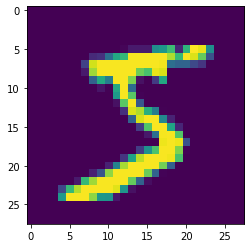

In [2]:
# --- Load data ---
from keras.datasets import mnist
from keras.utils import np_utils

# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# --- Checking size of MNIST Set ---
print("The number of training examples: "+str(X_train.shape))
print("The number of test examples: "+str(X_test.shape))

# --- Y_train to categorical ---
# Need to change these from numbers to categories
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

# --- Plotting data ---
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

## Keras

In [3]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import os
import random
import numpy as np
import tensorflow as tf
from keras.initializers import glorot_uniform
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical


# %% --------------------------------------- Set-Up --------------------------------------------------------------------
# Sets random seeds and some other stuff for reproducibility. Note even this might not give fully reproducible results.
# There seems to be a problem with the TF backend. However, the results should be very similar.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
weight_init = glorot_uniform(seed=SEED)

# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
LR = 1e-3
N_NEURONS = (100, 200, 100)
N_EPOCHS = 20
BATCH_SIZE = 512
DROPOUT = 0.2

# %% -------------------------------------- Data Prep ------------------------------------------------------------------
# Downloads from the internet and loads data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Reshapes to (n_examples, n_pixels), i.e, each pixel will be an input feature to the model
x_train, x_test = x_train.reshape(len(x_train), -1), x_test.reshape(len(x_test), -1)
y_train, y_test = to_categorical(y_train, num_classes=10), to_categorical(y_test, num_classes=10)

# %% -------------------------------------- Training Prep ----------------------------------------------------------
model = Sequential([  # The dropout is placed right after the outputs of the hidden layers.
    Dense(N_NEURONS[0], input_dim=784, kernel_initializer=weight_init),  # This sets some of these outputs to 0, so that
    Activation("relu"),  # a random dropout % of the hidden neurons are not used during each training step,
    Dropout(DROPOUT),  # nor are they updated. The Batch Normalization normalizes the outputs from the hidden
    BatchNormalization()  # activation functions. This helps with neuron imbalance and can speed training significantly.
])  # Note this is an actual layer with some learnable parameters. It's not just min-maxing or standardizing.
# Loops over the hidden dims to add more layers
for n_neurons in N_NEURONS[1:]:
    model.add(Dense(n_neurons, activation="relu", kernel_initializer=weight_init))
    model.add(Dropout(DROPOUT, seed=SEED))
    model.add(BatchNormalization())
# Adds a final output layer with softmax to map to the 10 classes
model.add(Dense(10, activation="softmax", kernel_initializer=weight_init))
model.compile(optimizer=Adam(lr=LR), loss="categorical_crossentropy", metrics=["accuracy"])

# %% -------------------------------------- Training Loop ----------------------------------------------------------
# Trains the MLP, while printing validation loss and metrics at each epoch
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_test, y_test))

# %% ------------------------------------------ Final test -------------------------------------------------------------
print("Final accuracy on validations set:", 100*model.evaluate(x_test, y_test)[1], "%")

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.6212 - accuracy: 0.8090 - val_loss: 0.2038 - val_accuracy: 0.9395
Epoch 2/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.2508 - accuracy: 0.9256 - val_loss: 0.1467 - val_accuracy: 0.9559
Epoch 3/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.1905 - accuracy: 0.9435 - val_loss: 0.1208 - val_accuracy: 0.9630
Epoch 4/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.1554 - accuracy: 0.9539 - val_loss: 0.1090 - val_accuracy: 0.9665
Epoch 5/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.1356 - accuracy: 0.9591 - val_loss: 0.1030 - val_accuracy: 0.9692
Epoch 6/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.1234 - accuracy: 0.9623 - val_loss: 0.0949 - val_accuracy: 0.9713
Epoch 7/20
60000/60000 [==============================] - 1s 15us/st

## TensorFlow

In [4]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score


# %% --------------------------------------- Set-Up --------------------------------------------------------------------
# TensorFlow 2 runs on GPU by default if you have one, to make sure you can run tf.test.is_gpu_available() and
# doing tf.debugging.set_log_device_placement(True) will tell where each operation is being run
# Sets random seeds for reproducibility. Note that this will not yield fully reproducible results on GPU in most cases
# To know why, watch https://www.youtube.com/watch?v=Ys8ofBeR2kA
tf.random.set_seed(42)
np.random.seed(42)

# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
LR = 1e-3
N_NEURONS = (100, 200, 100)
N_EPOCHS = 20
BATCH_SIZE = 128
DROPOUT = 0.2


# %% -------------------------------------- MLP Class ------------------------------------------------------------------
class MLP(tf.keras.Model):
    """ MLP with 3 hidden layers """
    def __init__(self, hidden_dim1, hidden_dim2, hidden_dim3, dropout=DROPOUT):
        super(MLP, self).__init__()
        self.linear1 = tf.keras.layers.Dense(hidden_dim1, input_shape=(784,))
        # The Batch Normalization normalizes the outputs from the hidden activation functions. This helps with neuron
        self.linear1_bn = tf.keras.layers.BatchNormalization()  # imbalance and can speed training significantly.
        # Note this is an actual layer with some learnable parameters. It's not just min-maxing or standardizing
        self.linear2 = tf.keras.layers.Dense(hidden_dim2)
        self.linear2_bn = tf.keras.layers.BatchNormalization()
        self.linear3 = tf.keras.layers.Dense(hidden_dim3)
        self.linear3_bn = tf.keras.layers.BatchNormalization()
        self.out = tf.keras.layers.Dense(10)
        self.act = tf.nn.relu
        # The dropout is placed right after the outputs of the hidden layers. This sets some of these
        # self.drop = tf.keras.layers.Dropout(dropout)  # outputs to 0, so that a random dropout % of the hidden
        # neurons are not used during each training step, nor are they updated
        # This layer is broken... https://github.com/tensorflow/tensorflow/issues/25175. We will use a function instead
        self.drop = dropout
        self.training = True

    def call(self, x):
        out = tf.nn.dropout(self.linear1_bn(self.act(self.linear1(x)), training=self.training), self.drop)
        out = tf.nn.dropout(self.linear2_bn(self.act(self.linear2(out)), training=self.training), self.drop)
        return self.out(tf.nn.dropout(self.linear3_bn(self.act(self.linear3(out)), training=self.training), self.drop))


# Re-implements the MLP class with an arbitrary number of hidden layers. This way we don't need
# to create another class or modify the existing one if we want to try out more or less layers
class MLPList(tf.keras.Model):
    """ MLP with len(neurons_per_layer) hidden layers """
    def __init__(self, neurons_per_layer, dropout=DROPOUT):
        super(MLPList, self).__init__()
        self.model_layers = [tf.keras.Sequential([tf.keras.layers.Dense(neurons_per_layer[0], input_shape=(784,))])]
        self.model_layers[0].add(tf.keras.layers.ReLU())
        self.model_layers[0].add(tf.keras.layers.BatchNormalization())
        # self.model_layers[0].add(tf.keras.layers.Dropout(dropout))  # This layer is broken...
        # https://github.com/tensorflow/tensorflow/issues/25175  We will use a function instead
        for neurons in neurons_per_layer[1:]:
            self.model_layers.append(
                tf.keras.Sequential([
                    tf.keras.layers.Dense(neurons),
                    tf.keras.layers.ReLU(),
                    tf.keras.layers.BatchNormalization()])  # ,
                    # tf.keras.layers.Dropout(dropout)])
            )
        self.model_layers.append(tf.keras.layers.Dense(10))
        self.drop = dropout
        self.training = True

    def call(self, x):
        for layer in self.model_layers[:-1]:
            x = tf.nn.dropout(layer(x, training=self.training), self.drop)
        return self.model_layers[-1](x)


# %% -------------------------------------- Data Prep ------------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Reshapes to (n_examples, n_pixels), i.e, each pixel will be an input feature to the model
x_train, x_test = tf.reshape(x_train, (len(x_train), -1)), tf.reshape(x_test, (len(x_test), -1))
x_train, x_test = tf.dtypes.cast(x_train, tf.float32), tf.dtypes.cast(x_test, tf.float32)
y_train, y_test = tf.convert_to_tensor(y_train), tf.convert_to_tensor(y_test)

# %% ---------------------------------------- Training Prep ------------------------------------------------------------
# Using MLP instead of MLPList will give exactly the same results, as we have the exact same architecture
model = MLP(*N_NEURONS)
# model = MLPList(N_NEURONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
@tf.function
def train(x, y):
    model.training = True  # makes BatchNorm use the actual training data to compute the mean and std
    model.drop = DROPOUT  # Activates the dropouts for training
    with tf.GradientTape() as tape:
        logits = model(x)
        loss = criterion(y, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y, logits)

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
@tf.function
def eval(x, y):
    model.training = False  # makes BatchNorm use mean and std estimates computed during training
    model.drop = 0  # Deactivates the dropouts for inference
    # Here we don't use tf.GradientTape()
    logits = model(x)
    loss = criterion(y, logits)
    test_loss(loss)
    test_accuracy(y, logits)


# %% ---------------------------------------- Training Loop ------------------------------------------------------------
print("Starting training loop...")
for epoch in range(N_EPOCHS):

    for batch in range(len(x_train)//BATCH_SIZE + 1):  # Loops over the number of batches
        inds = slice(batch*BATCH_SIZE, (batch+1)*BATCH_SIZE)  # Gets a slice to index the data
        train(x_train[inds], y_train[inds])

    eval(x_test, y_test)

    print("Epoch {} | Train Loss {:.5f}, Train Acc {:.2f} - Test Loss {:.5f}, Test Acc {:.2f}".format(
        epoch, train_loss.result(), train_accuracy.result()*100, test_loss.result(), test_accuracy.result()*100))
    train_loss.reset_states(); train_accuracy.reset_states(); test_loss.reset_states(); test_accuracy.reset_states()

# %% ------------------------------------------- Final Test ------------------------------------------------------------
# Performs the final test on the CPU
with tf.device('/CPU:0'):
    model.training, model.drop = False, 0
    logits = model(x_test)
    print(accuracy_score(y_test.numpy(), tf.argmax(logits, axis=1).numpy())*100)

Starting training loop...
Epoch 0 | Train Loss 0.39814, Train Acc 87.84 - Test Loss 0.15504, Test Acc 95.05
Epoch 1 | Train Loss 0.18437, Train Acc 94.25 - Test Loss 0.12062, Test Acc 96.19
Epoch 2 | Train Loss 0.14172, Train Acc 95.67 - Test Loss 0.10148, Test Acc 96.82
Epoch 3 | Train Loss 0.11787, Train Acc 96.43 - Test Loss 0.09572, Test Acc 97.15
Epoch 4 | Train Loss 0.10499, Train Acc 96.76 - Test Loss 0.08599, Test Acc 97.39
Epoch 5 | Train Loss 0.09435, Train Acc 97.04 - Test Loss 0.08333, Test Acc 97.46
Epoch 6 | Train Loss 0.08669, Train Acc 97.23 - Test Loss 0.08163, Test Acc 97.41
Epoch 7 | Train Loss 0.07988, Train Acc 97.44 - Test Loss 0.08761, Test Acc 97.40
Epoch 8 | Train Loss 0.07413, Train Acc 97.65 - Test Loss 0.07054, Test Acc 97.81
Epoch 9 | Train Loss 0.06751, Train Acc 97.84 - Test Loss 0.07717, Test Acc 97.57
Epoch 10 | Train Loss 0.06410, Train Acc 97.91 - Test Loss 0.08322, Test Acc 97.61
Epoch 11 | Train Loss 0.06003, Train Acc 98.08 - Test Loss 0.08059, Tes

## PyTorch

In [5]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from sklearn.metrics import accuracy_score


# %% --------------------------------------- Set-Up --------------------------------------------------------------------
# Gets the device to move Tensors to (defaults to GPU (cuda) if available)
# If you want to use the CPU even when you have GPU, just do device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Sets random seeds and some other stuff for reproducibility
torch.manual_seed(42)  # Note that this does not always ensure reproducible results
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
LR = 1e-3
N_NEURONS = (100, 200, 100)
N_EPOCHS = 20
BATCH_SIZE = 512
DROPOUT = 0.2


# %% ----------------------------------- Helper Functions --------------------------------------------------------------
def acc(x, y, return_labels=False):
    """ Simple function to get the accuracy or the predicted labels. The label with the highest logit is chosen """
    with torch.no_grad():  # Explained on the training loop
        logits = model(x)  # (n_examples, n_labels) --> Need to operate on columns, so axis=1
        pred_labels = np.argmax(logits.cpu().numpy(), axis=1)
    if return_labels:
        return pred_labels
    else:
        return 100*accuracy_score(y.cpu().numpy(), pred_labels)


# %% -------------------------------------- MLP Class ------------------------------------------------------------------
class MLP(nn.Module):
    """ MLP with 3 hidden layers """
    def __init__(self, hidden_dim1, hidden_dim2, hidden_dim3, dropout=DROPOUT):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784, hidden_dim1)
        # The Batch Normalization normalizes the outputs from the hidden activation functions. This helps with neuron
        self.linear1_bn = nn.BatchNorm1d(hidden_dim1)  # imbalance and can speed training significantly. Note this is
        # an actual layer with some learnable parameters. It's not just min-maxing or standardizing
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear2_bn = nn.BatchNorm1d(hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.linear3_bn = nn.BatchNorm1d(hidden_dim3)
        self.out = nn.Linear(hidden_dim3, 10)
        self.act = torch.relu
        # The dropout is placed right after the outputs of the hidden layers. This sets some of these
        self.drop = nn.Dropout(dropout)  # outputs to 0, so that a random dropout % of the hidden
        # neurons are not used during each training step, nor are they updated

    def forward(self, x):
        out = self.drop(self.linear1_bn(self.act(self.linear1(x))))
        out = self.drop(self.linear2_bn(self.act(self.linear2(out))))
        return self.out(self.drop(self.linear3_bn(self.act(self.linear3(out)))))


# Re-implements the MLP class with an arbitrary number of hidden layers. This way we don't need
# to create another class or modify the existing one if we want to try out more or less layers
class MLPModuleList(nn.Module):
    """ MLP with len(neurons_per_layer) hidden layers """
    def __init__(self, neurons_per_layer, dropout=DROPOUT):
        super(MLPModuleList, self).__init__()
        dims = (784, *neurons_per_layer)  # Gets a tuple of (784, neurons_layer1, neurons_layer2, ...)
        self.layers = nn.ModuleList([  # Uses ModuleList to get a list of an arbitrary number of layers based on
            nn.Sequential(  # the length of neurons_per_layer. A simple python list does not work because
                nn.Linear(dims[i], dims[i+1]),  # model.parameters() will not look inside the list.
                nn.ReLU(),  # Sequential adds the operations we want one after the other under the same forward pass
                nn.BatchNorm1d(dims[i+1]),
                nn.Dropout(dropout)
            ) for i in range(len(dims)-1)
        ])
        self.layers.extend(nn.ModuleList([nn.Linear(neurons_per_layer[-1], 10)]))  # Equivalent to self.out on MLP class

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# %% -------------------------------------- Data Prep ------------------------------------------------------------------
# Downloads from the internet and loads data
# Reshapes to (n_examples, n_pixels), i.e, each pixel will be an input feature to the model
# Moves to device
data_train = datasets.MNIST(root='.', train=True, download=True)
x_train, y_train = data_train.data.view(len(data_train), -1).float().to(device), data_train.targets.to(device)
x_train.requires_grad = True
data_test = datasets.MNIST(root='.', train=False, download=True)
x_test, y_test = data_test.data.view(len(data_test), -1).float().to(device), data_test.targets.to(device)

# %% -------------------------------------- Training Prep ----------------------------------------------------------
# Using MLP instead of MLPModuleList will give exactly the same results, as we have the exact same architecture
model = MLP(*N_NEURONS).to(device)
# model = MLPModuleList(N_NEURONS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# %% -------------------------------------- Training Loop ----------------------------------------------------------
print("Starting training loop...")
for epoch in range(N_EPOCHS):

    loss_train = 0  # Initializes train loss which will be added up after going forward on each batch
    model.train()  # Activates Dropout and makes BatchNorm use the actual training data to compute the mean and std
    # (this is the default behaviour but will be changed later on the evaluation phase)
    for batch in range(len(x_train)//BATCH_SIZE + 1):  # Loops over the number of batches (n_examples//batch_size)
        inds = slice(batch*BATCH_SIZE, (batch+1)*BATCH_SIZE)  # Gets a slice to index the data
        optimizer.zero_grad()
        logits = model(x_train[inds])
        loss = criterion(logits, y_train[inds])
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

    model.eval()  # Deactivates Dropout and makes BatchNorm use mean and std estimates computed during training
    with torch.no_grad():  # The code inside will run without Autograd, which reduces memory usage, speeds up
        y_test_pred = model(x_test)  # computations and makes sure the model can't use the test data to learn
        loss = criterion(y_test_pred, y_test)
        loss_test = loss.item()

    print("Epoch {} | Train Loss {:.5f}, Train Acc {:.2f} - Test Loss {:.5f}, Test Acc {:.2f}".format(
        epoch, loss_train/batch, acc(x_train, y_train), loss_test, acc(x_test, y_test)))

Starting training loop...
Epoch 0 | Train Loss 0.45908, Train Acc 95.41 - Test Loss 0.16065, Test Acc 94.88
Epoch 1 | Train Loss 0.17851, Train Acc 96.99 - Test Loss 0.11651, Test Acc 96.37
Epoch 2 | Train Loss 0.13514, Train Acc 97.71 - Test Loss 0.10081, Test Acc 97.00
Epoch 3 | Train Loss 0.11574, Train Acc 98.02 - Test Loss 0.09425, Test Acc 97.04
Epoch 4 | Train Loss 0.09865, Train Acc 98.32 - Test Loss 0.08709, Test Acc 97.47
Epoch 5 | Train Loss 0.08607, Train Acc 98.56 - Test Loss 0.08879, Test Acc 97.28
Epoch 6 | Train Loss 0.07999, Train Acc 98.82 - Test Loss 0.08281, Test Acc 97.69
Epoch 7 | Train Loss 0.07405, Train Acc 98.97 - Test Loss 0.07792, Test Acc 97.69
Epoch 8 | Train Loss 0.06925, Train Acc 99.05 - Test Loss 0.07999, Test Acc 97.76
Epoch 9 | Train Loss 0.06279, Train Acc 99.10 - Test Loss 0.07972, Test Acc 97.72
Epoch 10 | Train Loss 0.05885, Train Acc 99.17 - Test Loss 0.07640, Test Acc 97.92
Epoch 11 | Train Loss 0.05526, Train Acc 99.28 - Test Loss 0.07428, Tes

# Exercise: 
Train a MLP on the FashionMNIST dataset, which is exactly the same as the MNIST dataset but replacing the digits with images of different types of clothing. It was made to have a harder benchmark for image classification models. The adaptation from example_MNIST.py is thus trivial, although the MLP accuracy is 10% lower than on the MNIST dataset.



In [6]:
# %% -------------------------------------------------------------------------------------------------------------------

# % -------------------------------------------------------------------------------------
# Fit a MLP to the FashionMNIST dataset: https://github.com/zalandoresearch/fashion-mnist
# % -------------------------------------------------------------------------------------

# 1. Download the data using datasets.FashionMNIST

# 2. Try using more/less layers and different hidden sizes to get a good better fit. Also play with the dropout.
# Try different batch sizes and get a feeling of how they can influence convergence and speed

# 3. Add an option to save the model on each epoch, and stop saving it when the validation
# loss begins to increase (early stopping) - https://pytorch.org/tutorials/beginner/saving_loading_models.html

# 4. Add an option to only test the model, by loading the model you saved on the training phase

# 5. Print out the confusion matrix

# 6. Define a function to show some images that were incorrectly classified


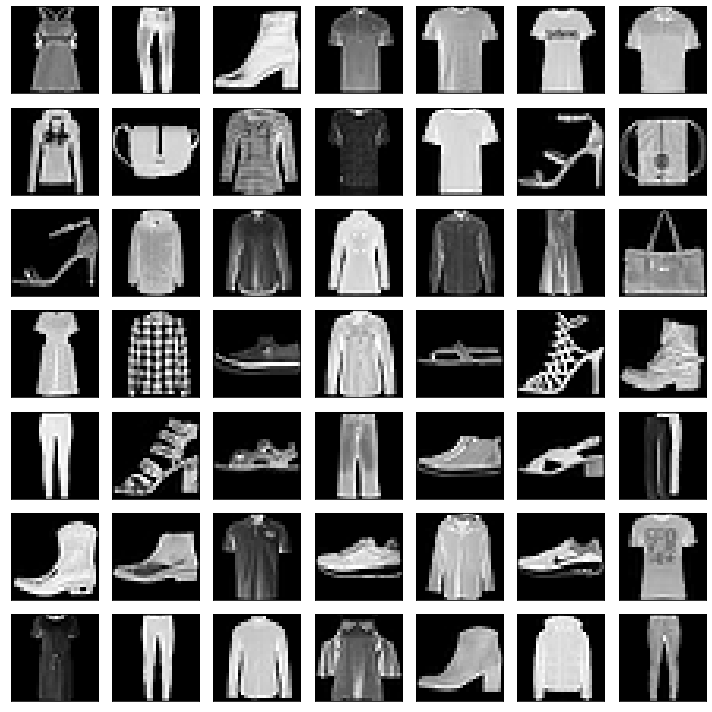

In [7]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# Sample images
ROW = 7
COLUMN = 7
plt.figure(figsize=(10, 10)) 
for i in range(ROW * COLUMN):
    temp = random.randint(0, len(x_train)+1)
    image = x_train[temp] 
    plt.subplot(ROW, COLUMN, i+1)       
    plt.imshow(image, cmap='gray')  
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()   
    
plt.show()